# LSTM model with synthetic features

## Notebook set-up

In [1]:
# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve

# Internal imports
import perdrizet_helper_funcs

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)

# Save the index of the target column
target_column_index=data_df.columns.get_loc('incidents_binary')

# Get and show some summary statistics
total_disaster_months=len(data_df[data_df['incidents_binary'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months\n')

data_df.info()

Have 1986(4.7%) disaster months

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41899 entries, (1955, 'AK', 1) to (2019, 'WY', 12)
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   incidents                             41899 non-null  int64  
 1   month_sin                             41899 non-null  float64
 2   month_cos                             41899 non-null  float64
 3   AL                                    41899 non-null  int64  
 4   AR                                    41899 non-null  int64  
 5   AS                                    41899 non-null  int64  
 6   AZ                                    41899 non-null  int64  
 7   CA                                    41899 non-null  int64  
 8   CO                                    41899 non-null  int64  
 9   CT                                    41899 non-null  int64  
 10  DC                      

In [3]:
data_df.describe()

,incidents,month_sin,month_cos,AL,AR,AS,AZ,CA,CO,CT,...,WY,diff_detrended_incidents,linear_detrended_incidents,raw_clipped_incidents,diff_clipped_incidents,linear_clipped_incidents,raw_clipped_transformed_incidents,diff_clipped_transformed_incidents,linear_clipped_transformed_incidents,incidents_binary
count,41899.000000,4.189900e+04,4.189900e+04,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,...,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000,41899.000000
mean,0.915201,-1.793384e-03,-1.557622e-04,0.016874,0.017948,0.015442,0.015394,0.018616,0.018521,0.018616,...,0.016182,-0.012459,-0.005792,0.557504,-0.012459,-0.349950,0.129681,-0.001219,-0.478805,0.047400
std,7.531568,7.069399e-01,7.072882e-01,0.128801,0.132764,0.123304,0.123116,0.135167,0.134826,0.135167,...,0.126176,10.165626,7.441450,3.166784,10.165626,3.288088,0.624510,0.950321,0.978321,0.212495
min,0.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-509.000000,-6.895776,0.000000,-509.000000,-6.895776,0.000000,-6.925596,-2.629273,0.000000
25%,0.000000,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.276032,0.000000,0.000000,-1.276032,0.000000,0.000000,-1.063752,0.000000
50%,0.000000,-2.449294e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.377546,0.000000,0.000000,-0.377546,0.000000,0.000000,-0.369108,0.000000
75%,0.000000,5.000000e-01,8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.065837,0.000000,0.000000,-0.065837,0.000000,0.000000,-0.065789,0.000000
max,509.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,318.000000,503.777219,24.330250,318.000000,23.062362,3.885290,6.455201,3.831819,1.000000


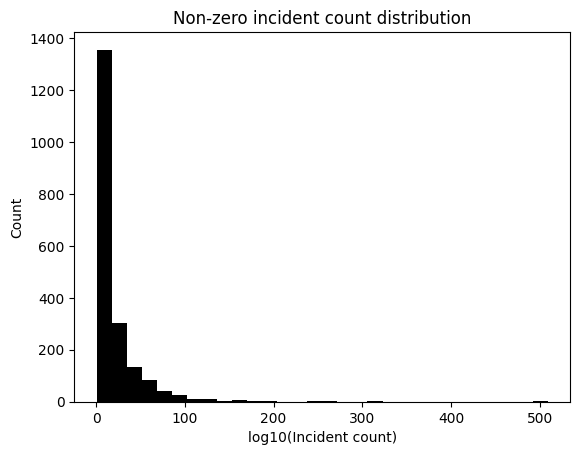

In [4]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Non-zero incident count distribution')
plt.hist(data_df['incidents'][data_df['incidents'] != 0], bins=30, color='black')
plt.xlabel('log10(Incident count)')
plt.ylabel('Count')
plt.show()

In [5]:
data_df.head()

incidents  month_sin     month_cos  AL  AR  AS  AZ  CA  CO  \
year state month                                                               
1955 AK    1              0   0.500000  8.660254e-01   0   0   0   0   0   0   
           2              0   0.866025  5.000000e-01   0   0   0   0   0   0   
           3              0   1.000000  6.123234e-17   0   0   0   0   0   0   
           4              0   0.866025 -5.000000e-01   0   0   0   0   0   0   
           5              0   0.500000 -8.660254e-01   0   0   0   0   0   0   

                  CT  ...  WY  diff_detrended_incidents  \
year state month      ...                                 
1955 AK    1       0  ...   0                       0.0   
           2       0  ...   0                       0.0   
           3       0  ...   0                       0.0   
           4       0  ...   0                       0.0   
           5       0  ...   0                       0.0   

                  linear_detrended_incidents  raw_clipped_incidents  \
year state month                                                      
1955 AK    1                        0.068259                    0.0   
           2                        0.067696                    0.0   
           3                        0.067187                    0.0   
           4                        0.066623                    0.0   
           5                        0.066079                    0.0   

                  diff_clipped_incidents  linear_clipped_incidents  \
year state month                                                     
1955 AK    1                         0.0                  0.068259   
           2                         0.0                  0.067696   
           3                         0.0                  0.067187   
           4                         0.0                  0.066623   
           5                         0.0                  0.066079   

                  raw_clipped_transformed_incidents  \
year state month                                      
1955 AK    1                                    0.0   
           2                                    0.0   
           3                                    0.0   
           4                                    0.0   
           5                                    0.0   

                  diff_clipped_transformed_incidents  \
year state month                                       
1955 AK    1                                     0.0   
           2                                     0.0   
           3                                     0.0   
           4                                     0.0   
           5                                     0.0   

                  linear_clipped_transformed_incidents  incidents_binary  
year state month                                                          
1955 AK    1                                  0.068206                 0  
           2                                  0.067644                 0  
           3                                  0.067136                 0  
           4                                  0.066574                 0  
           5                                  0.066031                 0  

[5 rows x 70 columns]

## 2. Train-test split

Take the most recent ~10% of the data for testing.

In [6]:
# Get list of years
years=data_df.index.get_level_values('year').unique().tolist()
testing_years=len(years) // 10
print(f'Using most recent {testing_years} of {len(years)} years for test set')
print(f'Testing years: {years[-testing_years:]}')
print(f'Training years: {years[:-testing_years]}')

# Take last 5 years for testing data
testing_df=data_df.loc[years[-testing_years:]]

# Take the rest for training
training_df=data_df.loc[years[:-testing_years]]

# Check result
training_df.head()

Using most recent 6 of 65 years for test set
Testing years: [2014, 2015, 2016, 2017, 2018, 2019]
Training years: [1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]


incidents  month_sin     month_cos  AL  AR  AS  AZ  CA  CO  \
year state month                                                               
1955 AK    1              0   0.500000  8.660254e-01   0   0   0   0   0   0   
           2              0   0.866025  5.000000e-01   0   0   0   0   0   0   
           3              0   1.000000  6.123234e-17   0   0   0   0   0   0   
           4              0   0.866025 -5.000000e-01   0   0   0   0   0   0   
           5              0   0.500000 -8.660254e-01   0   0   0   0   0   0   

                  CT  ...  WY  diff_detrended_incidents  \
year state month      ...                                 
1955 AK    1       0  ...   0                       0.0   
           2       0  ...   0                       0.0   
           3       0  ...   0                       0.0   
           4       0  ...   0                       0.0   
           5       0  ...   0                       0.0   

                  linear_detrended_incidents  raw_clipped_incidents  \
year state month                                                      
1955 AK    1                        0.068259                    0.0   
           2                        0.067696                    0.0   
           3                        0.067187                    0.0   
           4                        0.066623                    0.0   
           5                        0.066079                    0.0   

                  diff_clipped_incidents  linear_clipped_incidents  \
year state month                                                     
1955 AK    1                         0.0                  0.068259   
           2                         0.0                  0.067696   
           3                         0.0                  0.067187   
           4                         0.0                  0.066623   
           5                         0.0                  0.066079   

                  raw_clipped_transformed_incidents  \
year state month                                      
1955 AK    1                                    0.0   
           2                                    0.0   
           3                                    0.0   
           4                                    0.0   
           5                                    0.0   

                  diff_clipped_transformed_incidents  \
year state month                                       
1955 AK    1                                     0.0   
           2                                     0.0   
           3                                     0.0   
           4                                     0.0   
           5                                     0.0   

                  linear_clipped_transformed_incidents  incidents_binary  
year state month                                                          
1955 AK    1                                  0.068206                 0  
           2                                  0.067644                 0  
           3                                  0.067136                 0  
           4                                  0.066574                 0  
           5                                  0.066031                 0  

[5 rows x 70 columns]

## 3. Feature scaling

In [7]:
# Scale each column to (0,1) - first fit the MinMax scaler on the training df
scaler=MinMaxScaler()
scaler.fit(np.array(training_df))

# Then scale the training and testing data
scaled_training_data=scaler.transform(np.array(training_df))
scaled_testing_data=scaler.transform(np.array(testing_df))

# Rebuild the dataframes
scaled_training_df=pd.DataFrame(scaled_training_data, columns=training_df.columns.astype(str))
scaled_training_df.set_index(training_df.index, inplace=True)

scaled_testing_df=pd.DataFrame(scaled_testing_data, columns=testing_df.columns.astype(str))
scaled_testing_df.set_index(testing_df.index, inplace=True)

# Check the result
scaled_training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
incidents,37867.0,0.001664,0.013869,0.0,0.000000,0.000000,0.000000,1.0
month_sin,37867.0,0.499008,0.353461,0.0,0.066987,0.500000,0.750000,1.0
month_cos,37867.0,0.499914,0.353654,0.0,0.066987,0.500000,0.933013,1.0
AL,37867.0,0.016769,0.128407,0.0,0.000000,0.000000,0.000000,1.0
AR,37867.0,0.017958,0.132799,0.0,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...
linear_clipped_incidents,37867.0,0.202251,0.107929,0.0,0.172438,0.200066,0.209735,1.0
raw_clipped_transformed_incidents,37867.0,0.032024,0.157043,0.0,0.000000,0.000000,0.000000,1.0
diff_clipped_transformed_incidents,37867.0,0.525881,0.070295,0.0,0.525948,0.525948,0.525948,1.0
linear_clipped_transformed_incidents,37867.0,0.328681,0.147380,0.0,0.242533,0.344664,0.388212,1.0


## 3. Data formatting & training-validation splitting

In [8]:
# Run custom splitting function
training_features, training_labels, validation_features, validation_labels, states=perdrizet_helper_funcs.make_time_course(scaled_training_df)

# Check the result
print(f'State batches: {len(training_features)}')

for state, features, labels in zip(states, training_features, training_labels):
    print(f'{state}: features: {features.shape}, labels: {labels.shape}')

State batches: 58
AK: features: (494, 1, 70), labels: (494, 1)
CA: features: (494, 1, 70), labels: (494, 1)
CO: features: (491, 1, 70), labels: (491, 1)
CT: features: (494, 1, 70), labels: (494, 1)
FL: features: (494, 1, 70), labels: (494, 1)
GA: features: (494, 1, 70), labels: (494, 1)
HI: features: (492, 1, 70), labels: (492, 1)
IA: features: (494, 1, 70), labels: (494, 1)
IN: features: (494, 1, 70), labels: (494, 1)
KS: features: (491, 1, 70), labels: (491, 1)
LA: features: (494, 1, 70), labels: (494, 1)
MA: features: (494, 1, 70), labels: (494, 1)
ME: features: (494, 1, 70), labels: (494, 1)
MI: features: (494, 1, 70), labels: (494, 1)
MS: features: (494, 1, 70), labels: (494, 1)
MT: features: (494, 1, 70), labels: (494, 1)
NC: features: (494, 1, 70), labels: (494, 1)
NH: features: (494, 1, 70), labels: (494, 1)
NJ: features: (489, 1, 70), labels: (489, 1)
NM: features: (494, 1, 70), labels: (494, 1)
NV: features: (494, 1, 70), labels: (494, 1)
NY: features: (494, 1, 70), labels: (

## 4. Initial model training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM.1 (LSTM)               (None, 1, 1024)           4485120   
                                                                 
 LSTM.2 (LSTM)               (None, 1, 512)            3147776   
                                                                 
 LSTM.3 (LSTM)               (None, 256)               787456    
                                                                 
 dense.1 (Dense)             (None, 256)               65792     
                                                                 
 dense.2 (Dense)             (None, 128)               32896     
                                                                 
 dense.3 (Dense)             (None, 32)                4128      
                                                                 
 output (Dense)              (None, 1)                 3

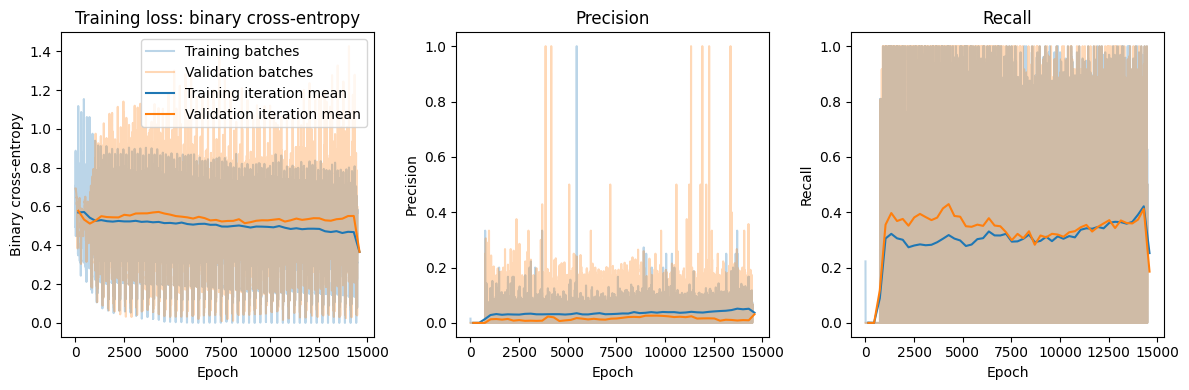

CPU times: user 21min 24s, sys: 1min 48s, total: 23min 13s
Wall time: 20min 17s


In [9]:
%%time

# Training details
training_iterations=50
training_epochs=5
learning_rate=0.0001

# Build the model
model=perdrizet_helper_funcs.build_lstm(
    training_features[0].shape[1],
    training_features[0].shape[2],
    learning_rate=learning_rate
)

# Print out the model structure
model.summary()

# Get the class weights
class_weight=perdrizet_helper_funcs.get_class_weights(scaled_training_df)

# Manually train the model iteratively over the state time courses using each for a single batch training run
true_epoch=0
training_results=[]
metrics=['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall']

for iteration in range(training_iterations):

    # Make an empty dict to store metric results for this iteration
    metric_data={}

    for metric in metrics:
        metric_data[metric]=[]

    # Loop over the state time courses
    for i in range(len(training_features)):

        # Count total training epochs
        true_epoch+=1

        # Train on this state
        batch_result, model=perdrizet_helper_funcs.train_lstm(
            model,
            training_features[i],
            training_labels[i],
            validation_features[i],
            validation_labels[i],
            class_weight,
            epochs=training_epochs,
            batch_size=training_features[i].shape[0]
        )

        # Collect the state-level training result
        training_results.append(batch_result)

        # Collect metrics for state-level training run
        for metric in metrics:
            metric_data[metric].extend(batch_result.history[metric])

    # Print metic means across states for every 5th iteration
    if iteration % 10 == 0:
        print(f'Training iteration {iteration} mean: ', end='')

        for metric in metrics:
            print(f'{metric}={sum(metric_data[metric])/len(metric_data[metric]):.3f} ', end='')
        
        print()

# Draw the training curves
perdrizet_helper_funcs.plot_single_training_run(
    training_results,
    len(states),
    training_epochs
).show()

## 5. Model evaluation

### 5.1. Make predictions on test set

In [10]:
# Format test data for predictions
testing_features=[]
testing_labels=[]

for i in range(len(scaled_testing_df) - 1):

    testing_features.append([scaled_testing_df.iloc[i]])
    testing_labels.append([scaled_testing_df.iloc[i + 1]['incidents_binary']])

# Check the result
print(f'Testing features shape: {np.array(testing_features).shape}')
print(f'Testing labels shape: {np.array(testing_labels).shape}')

Testing features shape: (4031, 1, 70)
Testing labels shape: (4031, 1)


In [11]:
# Make the predictions
predictions=[]

for features in testing_features:
    predictions.extend(model.predict(np.array([features]), verbose=0))

predictions_df=pd.DataFrame.from_dict({'labels': np.array(testing_labels).flatten(), 'probabilities': np.array(predictions).flatten()})
predictions_df.head()

,labels,probabilities
0,0.0,0.442390
1,0.0,0.260516
2,0.0,0.175797
3,0.0,0.398849
4,0.0,0.517701


### 5.2. Distribution of predicted incident probabilities

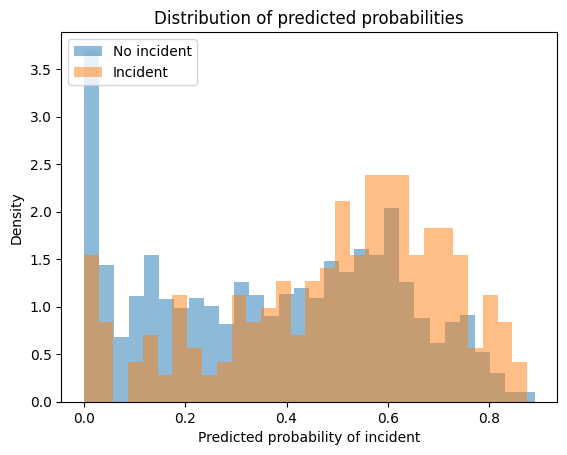

In [12]:
plt.title('Distribution of predicted probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### 5.3. Receiver-operator characteristic and precision-recall curves

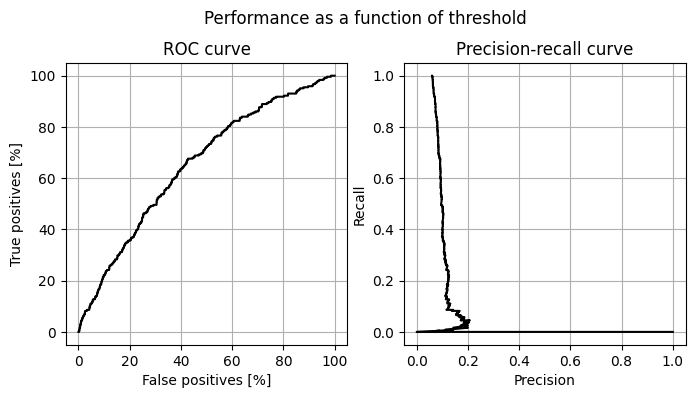

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('Performance as a function of threshold', size='large')

# Plot ROC curve
fp, tp, _ = roc_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _ = precision_recall_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

### 5.4. Confusion matrix

Precision: 0.094
Recall: 0.582



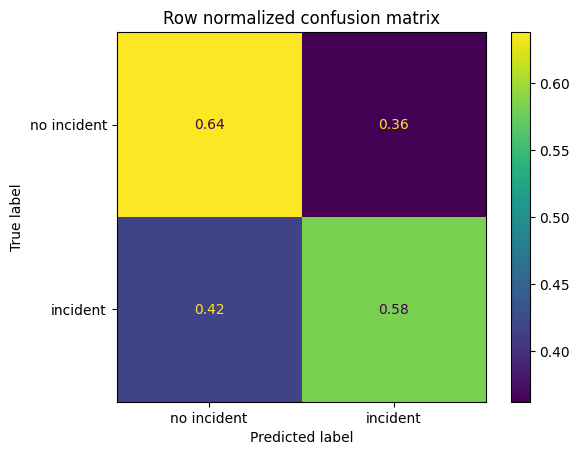

In [14]:
# Set threshold and call incidents
threshold=0.5
calls=np.where(predictions_df['probabilities'] > threshold, 1, 0)

# Calculate precision and recall
precision=precision_score(predictions_df['labels'], calls)
recall=recall_score(testing_labels, calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['labels'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title('Row normalized confusion matrix')
plt.show()